In [10]:
import pandas as pd
import re

from tqdm.notebook import tqdm

In [18]:
economics_df = pd.read_csv("../../../data/rosstat/orig/result_economics_df_v2_1.csv")

base_columns = ["code", "year", "quarter", "month"]

economic_characteristics = [
    "Изменение фондовооруженности",
    "Изменение фондоотдачи",
    "Обн. Осн. фондов в сопос ценах",
]
labor_and_employment_characteristics = [
    "Производительность труда",
    "Номинальная ЗП",
]  # "Численность занятых тыс" - много NaN
qualitative_characteristics = [
    "Высокопроизвод. Места",
    "Доля машин в общем объеме фонд",
    "Доля инвест на рекон и модерн",
]
overall_characteristics = ["Инд произв в % к соот мес", "Инд произв в % к пред мес"]

economics_df = economics_df[
    base_columns
    + economic_characteristics
    + labor_and_employment_characteristics
    + qualitative_characteristics
    + overall_characteristics
]

economics_df["date"] = (
    economics_df["year"].astype(str)
    + "-Q"
    + economics_df["quarter"].astype(str)
    + "-"
    + economics_df["month"].astype(str)
)
base_columns.append("date")

rename_dict = {
    "Изменение фондовооруженности": "capital_labor_ratio_change",
    "Изменение фондоотдачи": "capital_productivity_change",
    "Обн. Осн. фондов в сопос ценах": "fixed_assets_renewal_comparable_prices",
    "Номинальная ЗП": "nominal_wage",
    "Численность занятых тыс": "employment_thousands",
    "Высокопроизвод. Места": "high_productivity_jobs",
    "Доля машин в общем объеме фонд": "machinery_share_in_total_assets",
    "Доля инвест на рекон и модерн": "investment_share_for_modernization",
    "Инд произв в % к соот мес": "production_index_yoy",
    "Инд произв в % к пред мес": "production_index_mom",
    "Производительность труда": "labor_productivity",
}

economics_df = economics_df.rename(columns=rename_dict)

values_columns = list(set(economics_df.columns) - set(base_columns))

rows_to_drop = economics_df[values_columns].isna().all(axis=1)
economics_df = economics_df.drop(economics_df[rows_to_drop].index)

In [ ]:
## Проверю, что для моей целевой переменной ('nominal_wage')
# все отсутсвующие значения находятся
# или в начале временного ряда (не собирались ранее)
# или в конце временного ряда (ещё не были получены)

df_copy = economics_df.copy()

df_copy = df_copy.sort_values(['code', 'date'])
nan_mask = df_copy['nominal_wage'].isna()

rows_to_drop = pd.Series(False, index=df_copy.index)

unique_codes = df_copy['code'].unique()
for code in tqdm(unique_codes):
    code_data = df_copy[df_copy['code'] == code]
    
    search_for_trailing = False
    leading_nans = []
    for idx, row in code_data.iterrows():
        if pd.isna(row['nominal_wage']):
            leading_nans.append(idx)
        else:
            search_for_trailing = True
            break

    trailing_nans = []
    if search_for_trailing:
        for idx, row in code_data.iloc[::-1].iterrows():
            if pd.isna(row['nominal_wage']):
                trailing_nans.append(idx)
            else:
                break
    
    rows_to_drop.loc[leading_nans + trailing_nans] = True

economics_df_cleaned = df_copy[~rows_to_drop]

middle_nans = economics_df_cleaned.groupby('code')['nominal_wage'].apply(lambda x: x.isna().any())
if middle_nans.any():
    raise ValueError(f"Обнаружены NaN внутри временных рядов для следующих кодов: {middle_nans[middle_nans].index.tolist()}")

economics_df.dropna(subset=['nominal_wage'], inplace=True)


  0%|          | 0/2913 [00:00<?, ?it/s]

In [20]:
def detect_and_drop_leading_trailing_nans(df, columns_to_process):
    df_copy = df.copy()
    df_copy = df_copy.sort_values(['code', 'date'])
    
    rows_to_drop = pd.Series(False, index=df_copy.index)
    unique_codes = df_copy['code'].unique()
    
    middle_nans_info = {}
    
    for column in tqdm(columns_to_process, desc="Обработка колонок"):
        column_rows_to_drop = pd.Series(False, index=df_copy.index)
        
        for code in tqdm(unique_codes, desc=f"Коды для {column}", leave=False):
            code_data = df_copy[df_copy['code'] == code]
            
            search_for_trailing = False
            leading_nans = []
            
            for idx, row in code_data.iterrows():
                if pd.isna(row[column]):
                    leading_nans.append(idx)
                else:
                    search_for_trailing = True
                    break
            
            trailing_nans = []
            if search_for_trailing:
                for idx, row in code_data.iloc[::-1].iterrows():
                    if pd.isna(row[column]):
                        trailing_nans.append(idx)
                    else:
                        break
            
            column_rows_to_drop.loc[leading_nans + trailing_nans] = True
        
        rows_to_drop = rows_to_drop | column_rows_to_drop
        
        temp_cleaned = df_copy[~column_rows_to_drop]
        middle_nans = temp_cleaned.groupby('code')[column].apply(lambda x: x.isna().any())
        
        if middle_nans.any():
            middle_nans_info[column] = middle_nans[middle_nans].index.tolist()
            print(f"Обнаружены NaN внутри временных рядов для колонки {column} у следующих кодов: {middle_nans[middle_nans].index.tolist()}")

columns_to_process = list(economics_df.columns[economics_df.isna().sum() != 0])
detect_and_drop_leading_trailing_nans(economics_df, columns_to_process)

Обработка колонок:   0%|          | 0/9 [00:00<?, ?it/s]

Коды для capital_labor_ratio_change:   0%|          | 0/2573 [00:00<?, ?it/s]

Коды для capital_productivity_change:   0%|          | 0/2573 [00:00<?, ?it/s]

Коды для fixed_assets_renewal_comparable_prices:   0%|          | 0/2573 [00:00<?, ?it/s]

Коды для nominal_wage:   0%|          | 0/2573 [00:00<?, ?it/s]

Коды для high_productivity_jobs:   0%|          | 0/2573 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
economics_df.dropna(subset=columns_to_process, inplace=True)
economics_df.reset_index(drop=True, inplace=True)

In [22]:
assert economics_df['code'].value_counts().min() >= 12 * 4 # 4 года

In [23]:
economics_df.isna().sum() / economics_df.shape[0]

code                                      0.0
year                                      0.0
quarter                                   0.0
month                                     0.0
capital_labor_ratio_change                0.0
capital_productivity_change               0.0
fixed_assets_renewal_comparable_prices    0.0
labor_productivity                        0.0
nominal_wage                              0.0
high_productivity_jobs                    0.0
machinery_share_in_total_assets           0.0
investment_share_for_modernization        0.0
production_index_yoy                      0.0
production_index_mom                      0.0
date                                      0.0
dtype: float64

/tmp/ipykernel_47003/3798688403.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_code = economics_df.groupby('code').apply(missing_values_ratio)


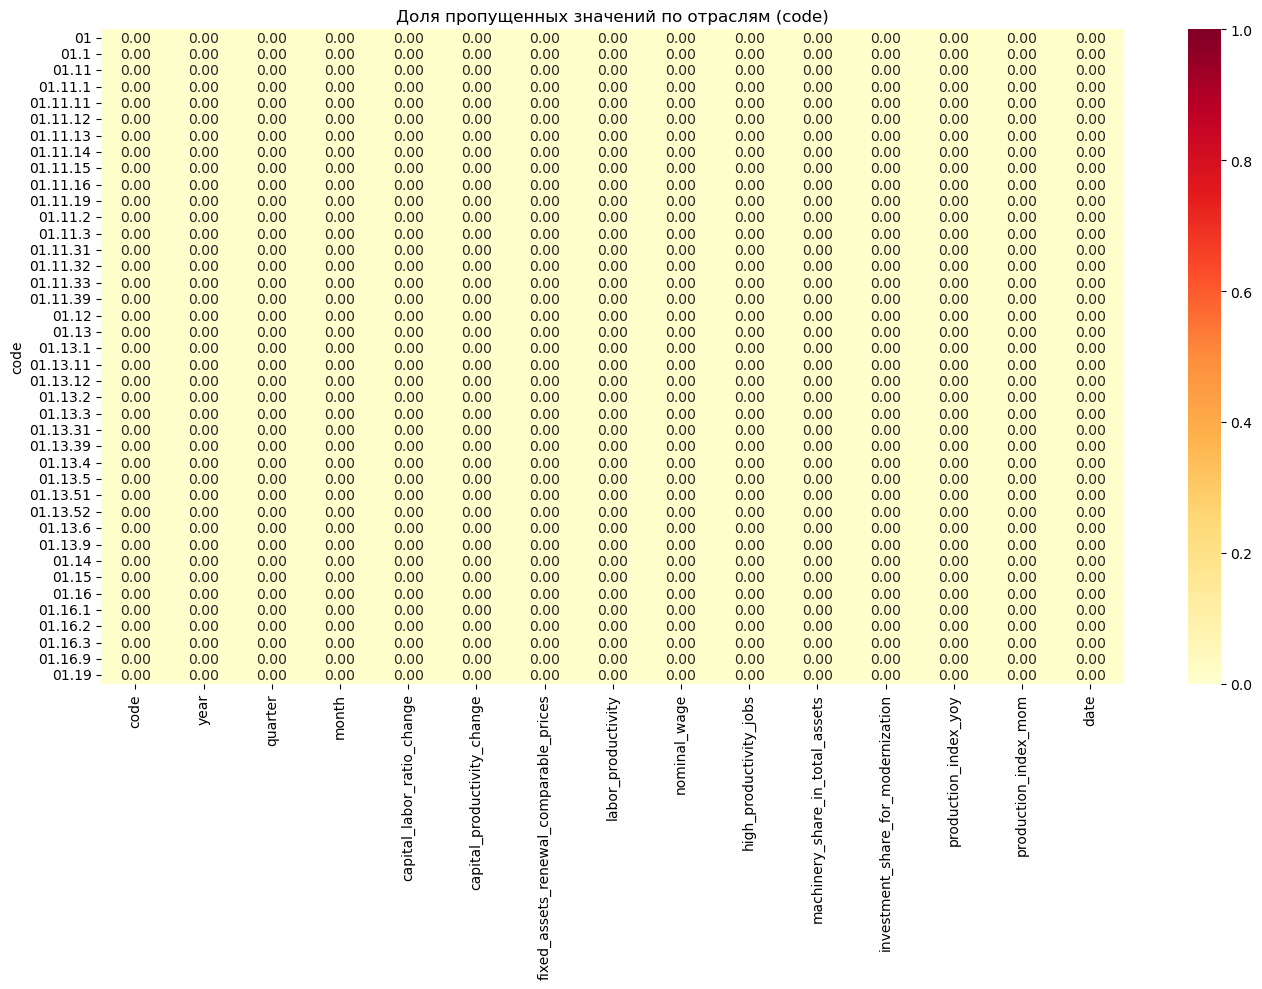

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

economics_df_subset = (
    economics_df[
        economics_df["code"].isin(economics_df["code"].value_counts().index[:20])
    ]
    .copy()
    .reset_index(drop=True)
)

def missing_values_ratio(df):
    return df.isna().sum() / df.shape[0]

missing_by_code = economics_df.groupby('code').apply(missing_values_ratio)

plt.figure(figsize=(14, 10))
sns.heatmap(missing_by_code[:40], cmap='YlOrRd', vmin=0, vmax=1, annot=True, fmt='.2f')
plt.title('Доля пропущенных значений по отраслям (code)')
plt.tight_layout()
plt.show()

In [38]:
def convert_custom_date(date_str):
    match = re.match(r'(\d{4})-Q(\d)-(\d{1,2})', date_str)
    if not match:
        return pd.NaT
    
    year, _, month = map(int, match.groups())
    
    return pd.Timestamp(year=year, month=month, day=1)

economics_df['date'] = economics_df['date'].apply(convert_custom_date)

In [1]:
import pandas as pd

economics_df = pd.read_csv('../../../data/rosstat/processed/result_economics_df_v1_0.csv')

In [12]:
main_codes = sorted(list(set([value.split('.', maxsplit=1)[0] for value in economics_df['code'].unique()])))

for code_for_check in main_codes:
    filtered_codes = [code for code in economics_df['code'].unique() if str(code).startswith(code_for_check)]

    filtered_df = economics_df[economics_df['code'].isin(filtered_codes)]

    wage_by_group = {}
    for code in filtered_codes:
        group = filtered_df[filtered_df['code'] == code]
        wage_by_group[code] = sorted(group['nominal_wage'].unique())

    reference_code = filtered_codes[0]
    reference_wages = wage_by_group[reference_code]

    same_wage_groups = []
    different_wage_groups = []

    for code in filtered_codes:
        current_wages = wage_by_group[code]
        if len(current_wages) == len(reference_wages) and all(w1 == w2 for w1, w2 in zip(current_wages, reference_wages)):
            same_wage_groups.append(code)
        else:
            different_wage_groups.append(code)

    if same_wage_groups != filtered_codes:
        raise ValueError(code_for_check)

In [18]:
economics_df = economics_df[economics_df['code'].isin(main_codes)].reset_index(drop=True)

In [ ]:
economics_df.drop(columns= ['year', 'quarter', 'month'], inplace=True)
economics_df.to_csv('../../../data/rosstat/processed/result_economics_df_v1_0.csv', index=False)